(file-types:notebooks)=
# Baroclinic modes for arbitrary stratification

This is an simple example of the eigenvalue problem module of Dedalus.

We solve the baroclinic mode for arbitrary stratification profiles. That
is, we solve the Sturm--Liouville problem: 
\begin{align}
&\frac{\mathrm{d}}{\mathrm{d}z}\left( \frac{f^2}{N^2}\frac{\mathrm{d}\psi}{\mathrm{d}z} \right) = -\lambda^2\psi\\
\text{with}\qquad &\frac{\mathrm{d}\psi}{\mathrm{d}z}(z=0)=\frac{\mathrm{d}\psi}{\mathrm{d}z}(z=-H)=0
\end{align}
where $N^2$ is a function of $z$.

We pose the problem on $H\in[-1,0]$ with $f^2/N^2(z)=e^{z}$. Realistic
physical values only change the eigenvalues by a constant. 

In [23]:
import numpy as np
import dedalus.public as d3

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

plt.style.use('/mnt/c/Ryan_Data/Tools/Python_Tool/ryan_mplstyle.mplstyle')

Define the problem parameters

In [24]:
# Physical Parameters
f = 1
N0 = 1

# Numerics Parameters
Lz = 2*np.pi
Nz = 128

dtype = np.complex128

# Bases
Lzt, Lzb = 0, -Lz

coords = d3.CartesianCoordinates('z')
dist = d3.Distributor(coords, dtype=dtype)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(Lzb, Lzt))

# Substitutions
dz = lambda A: d3.Differentiate(A, coords['z'])

Define the problem fields

In [25]:
# Fields
N2 = dist.Field(bases=zbasis)

lamb2 = dist.Field()

psi = dist.Field(bases=zbasis )

# tau fields for the top and bottom boundary conditions
tau_psit = dist.Field( )
tau_psib = dist.Field( )

z = dist.local_grids(zbasis)

lift_basis = zbasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

Define the problem

In [26]:
N2['g'] = N0**2*np.exp(z)

# Problem
problem = d3.EVP([psi, tau_psit, tau_psib], eigenvalue=lamb2, namespace=locals())

problem.add_equation("dz( (f**2/N2)*dz(psi) ) + lift(tau_psit,-1) + lift(tau_psib,-2) + lamb2*psi = 0")
problem.add_equation("dz(psi)(z=Lzt) = 0"); problem.add_equation("dz(psi)(z=Lzb) = 0")

{'eqn': interp(Diff(<Field 137031801632144>), z=-6.283185307179586),
 'LHS': interp(Diff(<Field 137031801632144>), z=-6.283185307179586),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'valid_modes': array([ True]),
 'M': 0,
 'L': interp(Diff(<Field 137031801632144>), z=-6.283185307179586),
 'domain': <dedalus.core.domain.Domain at 0x7ca133c24850>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [27]:
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
evals = solver.eigenvalues

2025-06-10 17:47:36,333 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


One can access the eigenvakyes using ``solver.eigenvalues``. To access the eigenvector, use 
```
solver.set_state(i,0)
psi_evec = solver.state[0]['g']
```

We plot the eigenvectors with the four smallest eigenvalues.

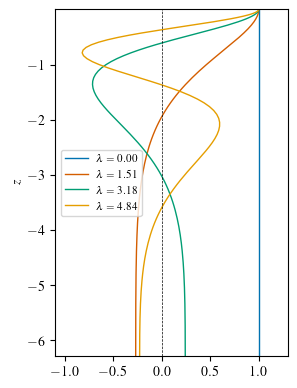

In [32]:
smallest_idx = np.argsort(evals.real)[:4]

fig=plt.figure(figsize=(3,4.5))

for i in smallest_idx:
    solver.set_state(i,0)
    psi_evec = np.real(solver.state[0]['g'])
    psi_evec /= psi_evec[np.argmax(np.abs(psi_evec))]

    plt.plot(psi_evec,z[0].ravel(),label=r"$\lambda=%.2f$" %np.real(evals[i]**0.5))

plt.axvline(0,color='k',linewidth=0.5,linestyle='--')
plt.xlim(-1.1,1.3)
plt.legend()
plt.ylabel("$z$")

plt.show()

There are many definitions of orthogonal vertical mode for the ocean.
For some examples, see
{cite}`SmithVanneste_13`, {cite}`LaCasce_17`, and
{cite}`YassinGriffies_22`. All these problems
can be solved by Dedalus, with more or less modification of the above
code. 

One could also input realistic stratification profiles from data,
interpolating them onto a Chebyshev grid of sufficient resolution. In
particular, this code reproduces the functionality of
<https://github.com/rabernat/oceanmodes>.